# Preparing the Graph Data for Geometric Pytorch

## Introduction to Pytorch Geometric
PyTorch Geometric (PyG) is a library that extends PyTorch, a popular machine learning framework, to handle graph-structured data. It is particularly suited for implementing graph neural networks (GNNs), which are powerful tools for learning from graph data. PyG provides easy-to-use interfaces and efficient data structures that make working with graphs in a deep learning context more accessible.

In this tutorial, we'll guide you through the process of converting disjunctive graphs, represented using Networkx, into PyG objects.


# Encoding Networkx Disjunctive Graphs as PyG Objects

## Understanding PyG Data Structures

The main PyG data structures are:

- **`torch_geometric.data.Data`**: This is the fundamental data structure in PyG. It represents a single graph instance and contains various attributes to describe a graph. Key attributes usually include:
   - `x`: Node feature matrix (shape: [num_nodes, num_node_features]).
   - `edge_index`: Graph connectivity in COO format (shape: [2, num_edges]).
   - `edge_attr`: Edge feature matrix (shape: [num_edges, num_edge_features]).
   - `y`: Target to train against (shape depends on the task; can be for nodes or the entire graph).
   - Additional attributes that depend on the specific requirements of the graph-based task or the nature of the graph data being handled.

- **`torch_geometric.data.Batch`**: This is used for batching multiple `Data` instances into a single graph. In the batched graph, individual graphs are disjoint, and this class provides the ability to recover individual examples. It inherits from `Data` and includes the `batch` attribute, which maps each node to its respective graph in the batch.

- **`torch_geometric.data.InMemoryDataset` and `torch_geometric.data.Dataset`**: These are two common types of datasets in PyG. `InMemoryDataset` loads the entire dataset into memory, while `Dataset` is more general and might load data on-the-fly.

- **`torch_geometric.data.DataLoader`**: This works in conjunction with `Dataset` to create mini-batches of graph data. It is a wrapper around `torch.utils.data.DataLoader` and takes care of collating individual `Data` objects into a batch (`Batch` object). They manage a collection of graph data (`Data` objects). Subclasses of `Dataset` usually override methods to download, process, and load graph data, making it easy to work with standard graph datasets.
These structures form the core of PyTorch Geometric and are fundamental in defining, manipulating, and processing graph data for various graph-based machine learning tasks.

In this tutorial we are going to create a small `InMemoryDataset` that we will use to train a Graph Neural Network into predicting the optimum value of the instance. For more information, PyG has an [official tutorial](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html) about how to create custom graph datasets. According to the tutorial:

"In order to create a torch_geometric.data.InMemoryDataset, you need to implement four fundamental methods:

- `InMemoryDataset.raw_file_names()`: A list of files in the raw_dir which needs to be found in order to skip the download.

- `InMemoryDataset.processed_file_names()`: A list of files in the processed_dir which needs to be found in order to skip the processing.

- `InMemoryDataset.download()`: Downloads raw data into raw_dir.

- `InMemoryDataset.process()`: Processes raw data and saves it into the processed_dir.

The real magic happens in the body of `process()`. Here, we need to read and create a list of Data objects and save it into the processed_dir. Because saving a huge python list is quite slow, we collate the list into one huge Data object via `torch_geometric.data.InMemoryDataset.collate()` before saving. The collated data object concatenates all examples into one big data object and, in addition, returns a slices dictionary to reconstruct single examples from this object. Finally, we need to load these two objects in the constructor into the properties self.data and self.slices."

In our case, since we are using PyG >= 2.4, "the functionalities of `torch.save()` and `InMemoryDataset.collate()` are unified and implemented behind `InMemoryDataset.save()`. Additionally, `self.data` and `self.slices` are implicitly loaded via `InMemoryDataset.load()`."

## Step 1: Transforming the Disjunctive Graph
We could create directly a Data object from the disjunctie graph of the instance using the `torch_geometric.utils.from_networkx` function. However, this would not create the node_features tensor `x`:


In [1]:
from gnn_scheduler.jssp import load_from_benchmark
from torch_geometric.utils import from_networkx

ft06 = load_from_benchmark("ft06")

# Remove T and S nodes from a copy of the graph
ft06_disjunctive_graph_copy = ft06.disjunctive_graph.copy()
ft06_disjunctive_graph_copy.remove_nodes_from(["T", "S"])

data = from_networkx(ft06_disjunctive_graph_copy)
print(data)

Data(edge_index=[2, 210], duration=[36], machine_id=[36], job_id=[36], position=[36], node_index=[36], type=[210], name='ft06', num_nodes=36)


That's the reason we need to preprocess the networkx graph to include all the node features we want. In particular, some possibilities are:

- **Operation Duration**: The processing time required for each operation, normalized by the maximum operation time across the graph to ensure this feature falls within a consistent range.

- **Machine Load**: A calculation of the total processing time that is scheduled for each machine, normalized by the maximum load across all machines, to provide a sense of how utilized each machine is.

- **Operation Index**: The sequential position of an operation within its job, represented as a fraction of the total number of operations in the job, to give the model insight into the operation's order without depending on the absolute number of operations.

- **Cumulative Processing Time**: The sum of processing times for all preceding operations within the same job, normalized against the maximum cumulative time in the graph, to give an idea of the work completed before the current operation.

- **Remaining Processing Time**: The sum of processing times for all subsequent operations within the same job, again normalized, to give an indication of the work that remains after the current operation.

- **Graph Topological Features**: Such as the degree of each node, which could help the model to identify critical operations that may affect other operations in terms of scheduling.

By incorporating these features into the networkx graph before converting it into a format suitable for PyTorch Geometric, we ensure that our model has access to all relevant information that could affect the optimal scheduling outcome. This preprocessing step is crucial for the GNN to make informed predictions.

In order to do so, we can use our `gnn_scheduler.data.preprocessing` package. This package includes several `NodeFeaturesCreator` classes that we can use to transform the data associated to each node in a networkx graph. You can even create your own `NodeFeaturesCreator` by inheriting from this class. Let's see an example using some of the predefined feature creators.

In [2]:
from gnn_scheduler.jssp.graphs import (
    Duration,
    MachineLoad,
    OperationIndex,
    preprocess_graph,
)
from gnn_scheduler.difficulty_prediction import get_difficulty_score

feature_creators = [Duration(), 
                    MachineLoad(),
                    OperationIndex()]
preprocessed_graph = preprocess_graph(ft06.disjunctive_graph,
                                      feature_creators,
                                      keep_old_features=False,
                                      remove_nodes=["S", "T"],
                                      copy=True)

data = from_networkx(preprocessed_graph)
data.y = get_difficulty_score(ft06)
print(data)

Data(x=[36, 3], edge_index=[2, 210], type=[210], name='ft06', y=0.17021276595744683)


In [3]:
data.x[:10]

tensor([[0.1000, 0.6047, 0.1667],
        [0.3000, 0.9302, 0.3333],
        [0.6000, 0.6047, 0.5000],
        [0.7000, 0.5116, 0.6667],
        [0.3000, 1.0000, 0.8333],
        [0.6000, 0.9302, 1.0000],
        [0.8000, 0.6047, 0.1667],
        [0.5000, 0.6047, 0.3333],
        [1.0000, 0.9302, 0.5000],
        [1.0000, 1.0000, 0.6667]])

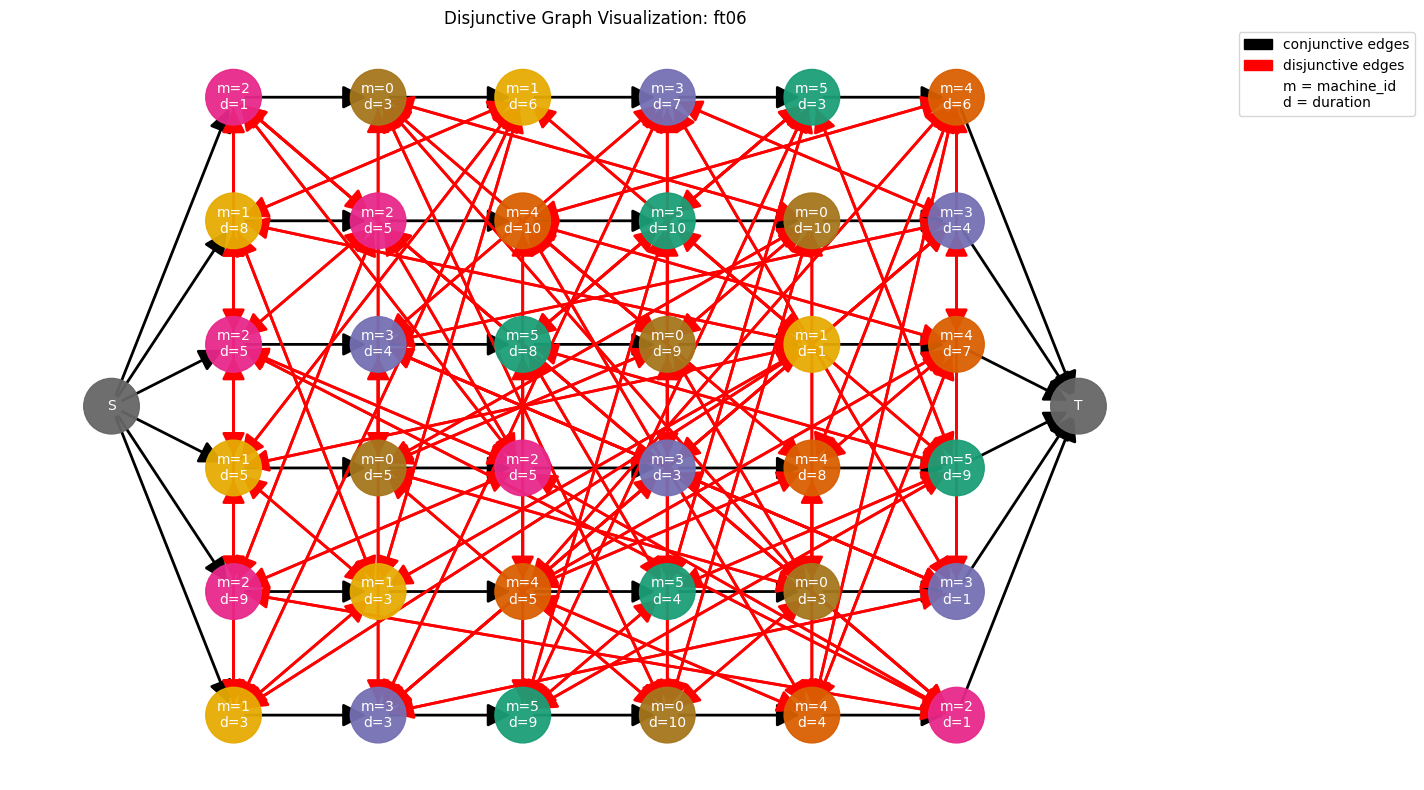

In [4]:
ft06.disjunctive_graph.plot();